Separate Buy/Sell Models - Training and Testing

[1/8] Loading datasets...
Training data shape: (3971, 71)
Testing data shape: (1148, 71)

[2/8] Identifying common features...
Common features found: 59

[3/8] Splitting data by direction...

Training data:
  Buy signals:    1791 samples ( 45.5%)
  Sell signals:   2147 samples ( 54.5%)

Testing data:
  Buy signals:     627 samples ( 55.9%)
  Sell signals:    494 samples ( 44.1%)

[4/8] Preparing train/validation splits...

Buy Model:
  Train: 1432, Val: 359, Test: 627

Sell Model:
  Train: 1717, Val: 430, Test: 494

[5/8] Training BUY model...
Best iteration: 114
Best validation score: 0.1015

[6/8] Training SELL model...
Best iteration: 83
Best validation score: 0.1013

[7/8] Evaluating models...

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
BUY MODEL PERFORMANCE
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

Validation Set:
  RMSE:  0.1015%
  MAE:   0.0698%
  R²:    0.9768
  Direction Accuracy: 96.38%

Testing Set:
  RMSE:  0.2855%
  MAE:   0.2

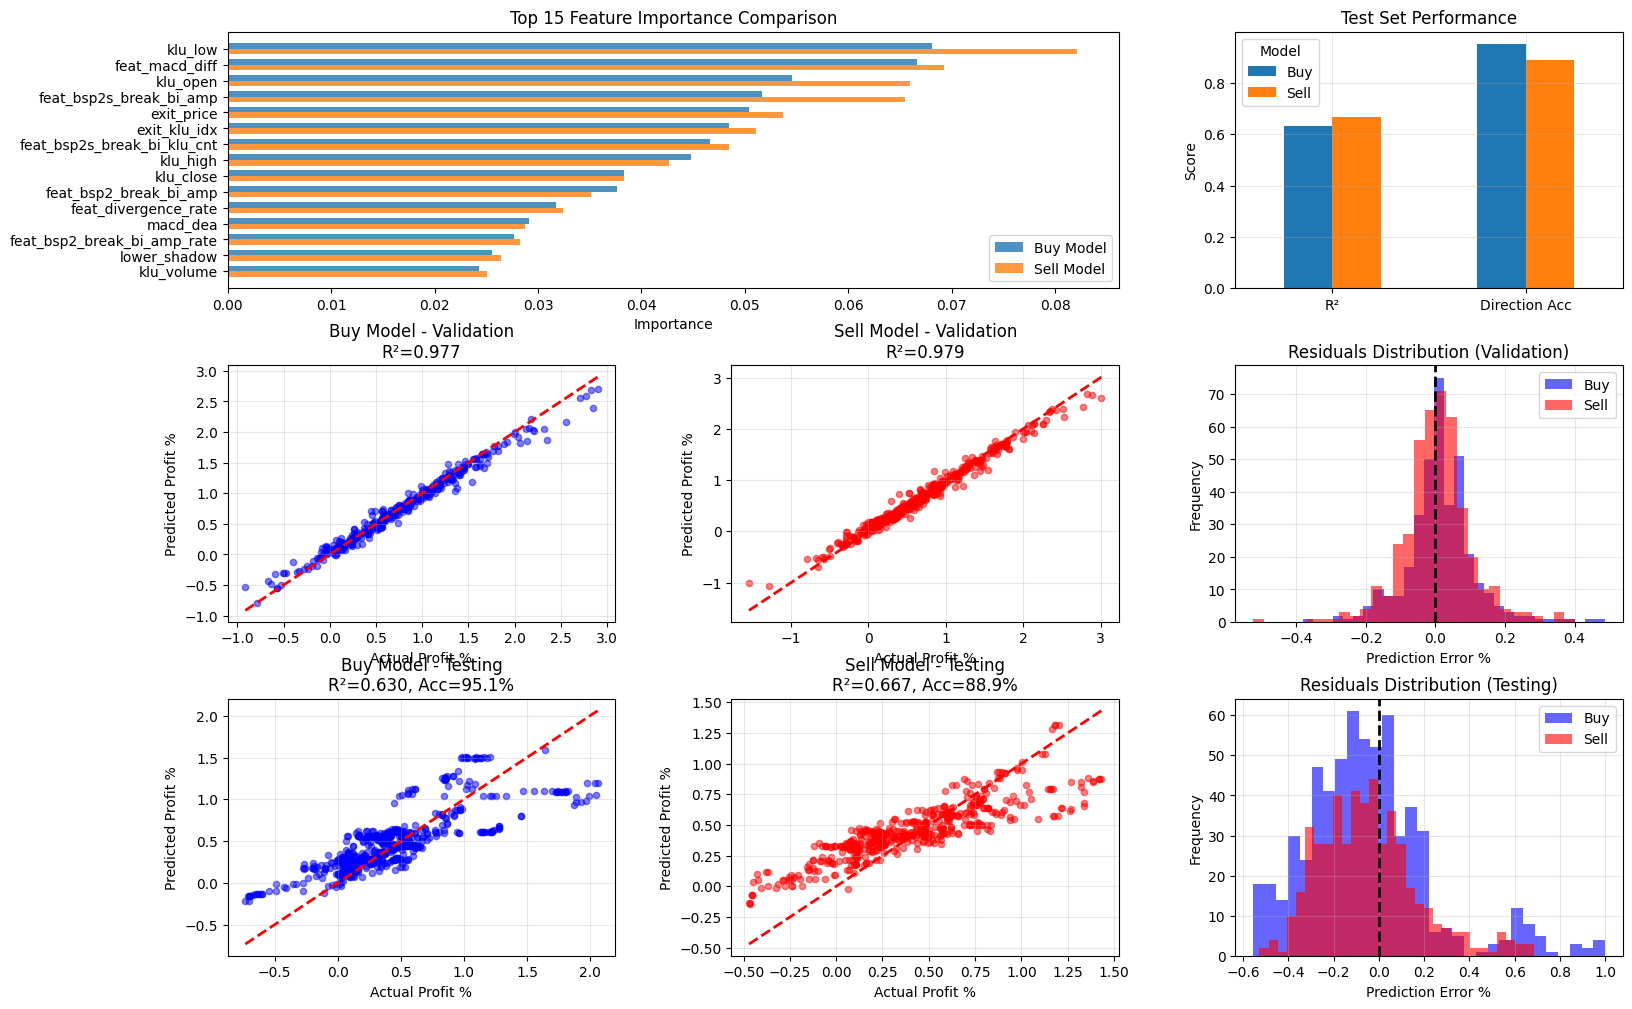

In [9]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configuration
TRAINING_DATA_PATH = "./output/enhanced_bs_features/^GSPC_ml_training_dataset_23.1.1-4.1.csv"
TESTING_DATA_PATH = "./output/testing_bs_features/^GSPC_testing_dataset_23.4.2-4.30.csv"
OUTPUT_DIR = "./output/model_results"
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

print("=" * 80)
print("Separate Buy/Sell Models - Training and Testing")
print("=" * 80)

# Load datasets
print("\n[1/8] Loading datasets...")
train_df = pd.read_csv(TRAINING_DATA_PATH)
test_df = pd.read_csv(TESTING_DATA_PATH)

print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

# Identify common features
print("\n[2/8] Identifying common features...")

# Exclude metadata and target columns
exclude_patterns = ['timestamp', 'bsp_type', 'direction', 'profit_target', 
                   'has_profit', 'return_', 'label_', 'target_return_', 
                   'snapshot_', 'klu_idx', 'exit_type']

train_cols = set(train_df.columns)
test_cols = set(test_df.columns)
common_cols = train_cols.intersection(test_cols)

# Filter to feature columns only
feature_cols = [col for col in common_cols 
                if not any(col.startswith(pattern) for pattern in exclude_patterns)]

# Remove encoded columns if original exists
if 'direction' in feature_cols and 'direction_encoded' in feature_cols:
    feature_cols.remove('direction')
if 'bsp_type' in feature_cols and 'bsp_type_encoded' in feature_cols:
    feature_cols.remove('bsp_type')

feature_cols = sorted(feature_cols)

print(f"Common features found: {len(feature_cols)}")

# Split data by direction
print("\n[3/8] Splitting data by direction...")

# Training data
train_valid = train_df[train_df['has_profit_target'] == 1].copy()
train_buy = train_valid[train_valid['direction'] == 'buy'].copy()
train_sell = train_valid[train_valid['direction'] == 'sell'].copy()

print(f"\nTraining data:")
print(f"  Buy signals:  {len(train_buy):>6} samples ({len(train_buy)/len(train_valid)*100:>5.1f}%)")
print(f"  Sell signals: {len(train_sell):>6} samples ({len(train_sell)/len(train_valid)*100:>5.1f}%)")

# Testing data
test_valid = test_df[test_df['has_profit_target'] == 1].copy()
test_buy = test_valid[test_valid['direction'] == 'buy'].copy()
test_sell = test_valid[test_valid['direction'] == 'sell'].copy()

print(f"\nTesting data:")
print(f"  Buy signals:  {len(test_buy):>6} samples ({len(test_buy)/len(test_valid)*100:>5.1f}%)")
print(f"  Sell signals: {len(test_sell):>6} samples ({len(test_sell)/len(test_valid)*100:>5.1f}%)")

# Prepare data splits for both models
print("\n[4/8] Preparing train/validation splits...")

def prepare_data_split(data, feature_cols):
    """Split data into train/val sets"""
    X_full = data[feature_cols]
    y_full = data['profit_target_pct']
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_full, y_full, 
        test_size=0.2, 
        random_state=42
    )
    
    # Handle missing values
    X_train = X_train.fillna(0)
    X_val = X_val.fillna(0)
    
    return X_train, X_val, y_train, y_val

# Buy model data
X_train_buy, X_val_buy, y_train_buy, y_val_buy = prepare_data_split(train_buy, feature_cols)
X_test_buy = test_buy[feature_cols].fillna(0)
y_test_buy = test_buy['profit_target_pct']

# Sell model data
X_train_sell, X_val_sell, y_train_sell, y_val_sell = prepare_data_split(train_sell, feature_cols)
X_test_sell = test_sell[feature_cols].fillna(0)
y_test_sell = test_sell['profit_target_pct']

print(f"\nBuy Model:")
print(f"  Train: {len(X_train_buy)}, Val: {len(X_val_buy)}, Test: {len(X_test_buy)}")
print(f"\nSell Model:")
print(f"  Train: {len(X_train_sell)}, Val: {len(X_val_sell)}, Test: {len(X_test_sell)}")

# Model parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'min_child_weight': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'n_jobs': -1,
    'early_stopping_rounds': 20
}

# Train Buy Model
print("\n[5/8] Training BUY model...")
print("=" * 60)

model_buy = xgb.XGBRegressor(**params)
model_buy.fit(
    X_train_buy, y_train_buy,
    eval_set=[(X_val_buy, y_val_buy)],
    verbose=False
)

try:
    print(f"Best iteration: {model_buy.best_iteration}")
    print(f"Best validation score: {model_buy.best_score:.4f}")
except AttributeError:
    print("Model trained successfully")

# Train Sell Model
print("\n[6/8] Training SELL model...")
print("=" * 60)

model_sell = xgb.XGBRegressor(**params)
model_sell.fit(
    X_train_sell, y_train_sell,
    eval_set=[(X_val_sell, y_val_sell)],
    verbose=False
)

try:
    print(f"Best iteration: {model_sell.best_iteration}")
    print(f"Best validation score: {model_sell.best_score:.4f}")
except AttributeError:
    print("Model trained successfully")

# Evaluate both models
print("\n[7/8] Evaluating models...")
print("=" * 80)

def calculate_metrics(y_true, y_pred, dataset_name):
    """Calculate and display performance metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Trading metrics
    correct_direction = np.sum((y_true > 0) == (y_pred > 0))
    accuracy = correct_direction / len(y_true) * 100
    
    print(f"\n{dataset_name}:")
    print(f"  RMSE: {rmse:>7.4f}%")
    print(f"  MAE:  {mae:>7.4f}%")
    print(f"  R²:   {r2:>7.4f}")
    print(f"  Direction Accuracy: {accuracy:>5.2f}%")
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Accuracy': accuracy,
        'predictions': y_pred
    }

# Buy model predictions
y_val_buy_pred = model_buy.predict(X_val_buy)
y_test_buy_pred = model_buy.predict(X_test_buy)

print("\n" + "▶" * 40)
print("BUY MODEL PERFORMANCE")
print("▶" * 40)
buy_val_metrics = calculate_metrics(y_val_buy, y_val_buy_pred, "Validation Set")
buy_test_metrics = calculate_metrics(y_test_buy, y_test_buy_pred, "Testing Set")

# Sell model predictions
y_val_sell_pred = model_sell.predict(X_val_sell)
y_test_sell_pred = model_sell.predict(X_test_sell)

print("\n" + "▼" * 40)
print("SELL MODEL PERFORMANCE")
print("▼" * 40)
sell_val_metrics = calculate_metrics(y_val_sell, y_val_sell_pred, "Validation Set")
sell_test_metrics = calculate_metrics(y_test_sell, y_test_sell_pred, "Testing Set")

# Feature importance comparison
print("\n[8/8] Analyzing feature importance...")

feature_importance_buy = pd.DataFrame({
    'feature': feature_cols,
    'importance': model_buy.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance_sell = pd.DataFrame({
    'feature': feature_cols,
    'importance': model_sell.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Features - BUY Model:")
for i, row in feature_importance_buy.head(10).iterrows():
    print(f"  {row['feature']:40s}: {row['importance']:.4f}")

print("\nTop 10 Features - SELL Model:")
for i, row in feature_importance_sell.head(10).iterrows():
    print(f"  {row['feature']:40s}: {row['importance']:.4f}")

# Visualizations
print("\nGenerating visualizations...")

# 1. Model Comparison Dashboard
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Row 1: Feature Importance
ax1 = fig.add_subplot(gs[0, :2])
top_n = 15
top_buy = feature_importance_buy.head(top_n)
top_sell = feature_importance_sell.head(top_n)

x = np.arange(top_n)
width = 0.35

ax1.barh(x - width/2, top_buy['importance'].values, width, label='Buy Model', alpha=0.8)
ax1.barh(x + width/2, top_sell['importance'].values, width, label='Sell Model', alpha=0.8)
ax1.set_yticks(x)
ax1.set_yticklabels(top_buy['feature'].values)
ax1.set_xlabel('Importance')
ax1.set_title(f'Top {top_n} Feature Importance Comparison')
ax1.legend()
ax1.invert_yaxis()

# Performance comparison bar chart
ax2 = fig.add_subplot(gs[0, 2])
metrics_comparison = pd.DataFrame({
    'Buy': [buy_test_metrics['R2'], buy_test_metrics['Accuracy']/100],
    'Sell': [sell_test_metrics['R2'], sell_test_metrics['Accuracy']/100]
}, index=['R²', 'Direction Acc'])

metrics_comparison.plot(kind='bar', ax=ax2, rot=0)
ax2.set_title('Test Set Performance')
ax2.set_ylabel('Score')
ax2.legend(title='Model')
ax2.grid(True, alpha=0.3)

# Row 2: Predicted vs Actual - Validation
ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(y_val_buy, y_val_buy_pred, alpha=0.5, s=20, color='blue')
ax3.plot([y_val_buy.min(), y_val_buy.max()], 
         [y_val_buy.min(), y_val_buy.max()], 'r--', lw=2)
ax3.set_xlabel('Actual Profit %')
ax3.set_ylabel('Predicted Profit %')
ax3.set_title(f'Buy Model - Validation\nR²={buy_val_metrics["R2"]:.3f}')
ax3.grid(True, alpha=0.3)

ax4 = fig.add_subplot(gs[1, 1])
ax4.scatter(y_val_sell, y_val_sell_pred, alpha=0.5, s=20, color='red')
ax4.plot([y_val_sell.min(), y_val_sell.max()], 
         [y_val_sell.min(), y_val_sell.max()], 'r--', lw=2)
ax4.set_xlabel('Actual Profit %')
ax4.set_ylabel('Predicted Profit %')
ax4.set_title(f'Sell Model - Validation\nR²={sell_val_metrics["R2"]:.3f}')
ax4.grid(True, alpha=0.3)

# Residuals comparison
ax5 = fig.add_subplot(gs[1, 2])
buy_residuals = y_val_buy - y_val_buy_pred
sell_residuals = y_val_sell - y_val_sell_pred
ax5.hist(buy_residuals, bins=30, alpha=0.6, label='Buy', color='blue')
ax5.hist(sell_residuals, bins=30, alpha=0.6, label='Sell', color='red')
ax5.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax5.set_xlabel('Prediction Error %')
ax5.set_ylabel('Frequency')
ax5.set_title('Residuals Distribution (Validation)')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Row 3: Predicted vs Actual - Testing
ax6 = fig.add_subplot(gs[2, 0])
ax6.scatter(y_test_buy, y_test_buy_pred, alpha=0.5, s=20, color='blue')
ax6.plot([y_test_buy.min(), y_test_buy.max()], 
         [y_test_buy.min(), y_test_buy.max()], 'r--', lw=2)
ax6.set_xlabel('Actual Profit %')
ax6.set_ylabel('Predicted Profit %')
ax6.set_title(f'Buy Model - Testing\nR²={buy_test_metrics["R2"]:.3f}, Acc={buy_test_metrics["Accuracy"]:.1f}%')
ax6.grid(True, alpha=0.3)

ax7 = fig.add_subplot(gs[2, 1])
ax7.scatter(y_test_sell, y_test_sell_pred, alpha=0.5, s=20, color='red')
ax7.plot([y_test_sell.min(), y_test_sell.max()], 
         [y_test_sell.min(), y_test_sell.max()], 'r--', lw=2)
ax7.set_xlabel('Actual Profit %')
ax7.set_ylabel('Predicted Profit %')
ax7.set_title(f'Sell Model - Testing\nR²={sell_test_metrics["R2"]:.3f}, Acc={sell_test_metrics["Accuracy"]:.1f}%')
ax7.grid(True, alpha=0.3)

# Test residuals
ax8 = fig.add_subplot(gs[2, 2])
buy_test_residuals = y_test_buy - y_test_buy_pred
sell_test_residuals = y_test_sell - y_test_sell_pred
ax8.hist(buy_test_residuals, bins=30, alpha=0.6, label='Buy', color='blue')
ax8.hist(sell_test_residuals, bins=30, alpha=0.6, label='Sell', color='red')
ax8.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax8.set_xlabel('Prediction Error %')
ax8.set_ylabel('Frequency')
ax8.set_title('Residuals Distribution (Testing)')
ax8.legend()
ax8.grid(True, alpha=0.3)

plt.savefig(f"{OUTPUT_DIR}/separate_models_comparison.png", dpi=150, bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR}/separate_models_comparison.png")

# Save results
print("\nSaving detailed results...")

# Buy model results
test_buy_results = test_buy.copy()
test_buy_results['predicted_profit_pct'] = y_test_buy_pred
test_buy_results['prediction_error'] = y_test_buy - y_test_buy_pred
test_buy_results['correct_direction'] = (
    (test_buy_results['profit_target_pct'] > 0) == 
    (test_buy_results['predicted_profit_pct'] > 0)
).astype(int)
test_buy_results.to_csv(f"{OUTPUT_DIR}/buy_model_predictions.csv", index=False)

# Sell model results
test_sell_results = test_sell.copy()
test_sell_results['predicted_profit_pct'] = y_test_sell_pred
test_sell_results['prediction_error'] = y_test_sell - y_test_sell_pred
test_sell_results['correct_direction'] = (
    (test_sell_results['profit_target_pct'] > 0) == 
    (test_sell_results['predicted_profit_pct'] > 0)
).astype(int)
test_sell_results.to_csv(f"{OUTPUT_DIR}/sell_model_predictions.csv", index=False)

# Combined results for easy comparison
combined_results = pd.concat([test_buy_results, test_sell_results]).sort_values('klu_idx')
combined_results.to_csv(f"{OUTPUT_DIR}/combined_predictions.csv", index=False)

print(f"Saved: {OUTPUT_DIR}/buy_model_predictions.csv")
print(f"Saved: {OUTPUT_DIR}/sell_model_predictions.csv")
print(f"Saved: {OUTPUT_DIR}/combined_predictions.csv")

# Save models
model_buy.save_model(f"{OUTPUT_DIR}/xgboost_buy_model.json")
model_sell.save_model(f"{OUTPUT_DIR}/xgboost_sell_model.json")
print(f"Saved: {OUTPUT_DIR}/xgboost_buy_model.json")
print(f"Saved: {OUTPUT_DIR}/xgboost_sell_model.json")

# Save feature importance
feature_importance_buy.to_csv(f"{OUTPUT_DIR}/buy_model_feature_importance.csv", index=False)
feature_importance_sell.to_csv(f"{OUTPUT_DIR}/sell_model_feature_importance.csv", index=False)

# Summary report
with open(f"{OUTPUT_DIR}/separate_models_summary.txt", 'w') as f:
    f.write("Separate Buy/Sell Models - Summary Report\n")
    f.write("=" * 80 + "\n\n")
    
    f.write("DATA SPLIT:\n")
    f.write(f"  Training:\n")
    f.write(f"    Buy signals:  {len(train_buy):>6} samples\n")
    f.write(f"    Sell signals: {len(train_sell):>6} samples\n")
    f.write(f"  Testing:\n")
    f.write(f"    Buy signals:  {len(test_buy):>6} samples\n")
    f.write(f"    Sell signals: {len(test_sell):>6} samples\n\n")
    
    f.write("BUY MODEL PERFORMANCE:\n")
    f.write(f"  Validation:\n")
    f.write(f"    RMSE: {buy_val_metrics['RMSE']:.4f}%\n")
    f.write(f"    MAE:  {buy_val_metrics['MAE']:.4f}%\n")
    f.write(f"    R²:   {buy_val_metrics['R2']:.4f}\n")
    f.write(f"    Acc:  {buy_val_metrics['Accuracy']:.2f}%\n")
    f.write(f"  Testing:\n")
    f.write(f"    RMSE: {buy_test_metrics['RMSE']:.4f}%\n")
    f.write(f"    MAE:  {buy_test_metrics['MAE']:.4f}%\n")
    f.write(f"    R²:   {buy_test_metrics['R2']:.4f}\n")
    f.write(f"    Acc:  {buy_test_metrics['Accuracy']:.2f}%\n\n")
    
    f.write("SELL MODEL PERFORMANCE:\n")
    f.write(f"  Validation:\n")
    f.write(f"    RMSE: {sell_val_metrics['RMSE']:.4f}%\n")
    f.write(f"    MAE:  {sell_val_metrics['MAE']:.4f}%\n")
    f.write(f"    R²:   {sell_val_metrics['R2']:.4f}\n")
    f.write(f"    Acc:  {sell_val_metrics['Accuracy']:.2f}%\n")
    f.write(f"  Testing:\n")
    f.write(f"    RMSE: {sell_test_metrics['RMSE']:.4f}%\n")
    f.write(f"    MAE:  {sell_test_metrics['MAE']:.4f}%\n")
    f.write(f"    R²:   {sell_test_metrics['R2']:.4f}\n")
    f.write(f"    Acc:  {sell_test_metrics['Accuracy']:.2f}%\n\n")
    
    f.write("TOP 10 BUY MODEL FEATURES:\n")
    for i, row in feature_importance_buy.head(10).iterrows():
        f.write(f"  {i+1:2d}. {row['feature']:40s}: {row['importance']:.4f}\n")
    
    f.write("\nTOP 10 SELL MODEL FEATURES:\n")
    for i, row in feature_importance_sell.head(10).iterrows():
        f.write(f"  {i+1:2d}. {row['feature']:40s}: {row['importance']:.4f}\n")

print(f"Saved: {OUTPUT_DIR}/separate_models_summary.txt")

# Final summary
print("\n" + "=" * 80)
print("SEPARATE MODEL TRAINING COMPLETE")
print("=" * 80)

print(f"\n📊 BUY MODEL RESULTS:")
print(f"  Testing R²:               {buy_test_metrics['R2']:>7.4f}")
print(f"  Testing MAE:              {buy_test_metrics['MAE']:>7.4f}%")
print(f"  Direction Accuracy:       {buy_test_metrics['Accuracy']:>7.2f}%")

print(f"\n📊 SELL MODEL RESULTS:")
print(f"  Testing R²:               {sell_test_metrics['R2']:>7.4f}")
print(f"  Testing MAE:              {sell_test_metrics['MAE']:>7.4f}%")
print(f"  Direction Accuracy:       {sell_test_metrics['Accuracy']:>7.2f}%")

print(f"\n📈 COMPARISON:")
r2_diff = buy_test_metrics['R2'] - sell_test_metrics['R2']
acc_diff = buy_test_metrics['Accuracy'] - sell_test_metrics['Accuracy']

if abs(r2_diff) > 0.05:
    better = "BUY" if r2_diff > 0 else "SELL"
    print(f"  {better} model performs significantly better (R² diff: {abs(r2_diff):.3f})")
else:
    print(f"  Both models perform similarly (R² diff: {abs(r2_diff):.3f})")

if abs(acc_diff) > 5:
    better = "BUY" if acc_diff > 0 else "SELL"
    print(f"  {better} model has better direction accuracy ({abs(acc_diff):.1f}% difference)")

print(f"\n💾 All results saved to: {OUTPUT_DIR}/")
print(f"\n✅ Use 'buy_model' for buy signals and 'sell_model' for sell signals")

plt.show()

Portfolio Backtesting: Separate Buy/Sell Models vs Buy & Hold

[1/5] Loading model predictions...
[2/5] Loading S&P 500 historical data...
S&P 500 data points in test period: 1121
ML signals in test period: 1121
  - Buy signals:  627
  - Sell signals: 494
Date range: 2023/04/03 02:05 to 2023/04/28 07:10

[3/5] Running backtest with separate models...

[4/5] Calculating performance metrics...

BACKTEST RESULTS

Initial Capital: $10,000.00
Trading Period: 2023/04/03 02:05 to 2023/04/28 07:10
Total Days: 1121
Total ML Signals: 1121
Buy & Hold using: Full S&P 500 daily prices

--------------------------------------------------------------------------------
ML TRADING STRATEGY (Separate Buy/Sell Models)
--------------------------------------------------------------------------------
Strategy: Use BUY model for entries, SELL model for exits
  - Buy Threshold:  0.5% (from buy_model)
  - Sell Threshold: 0.5% (from sell_model)
Position Size: 100% per trade
Final Portfolio Value: $10,783.42
Tota

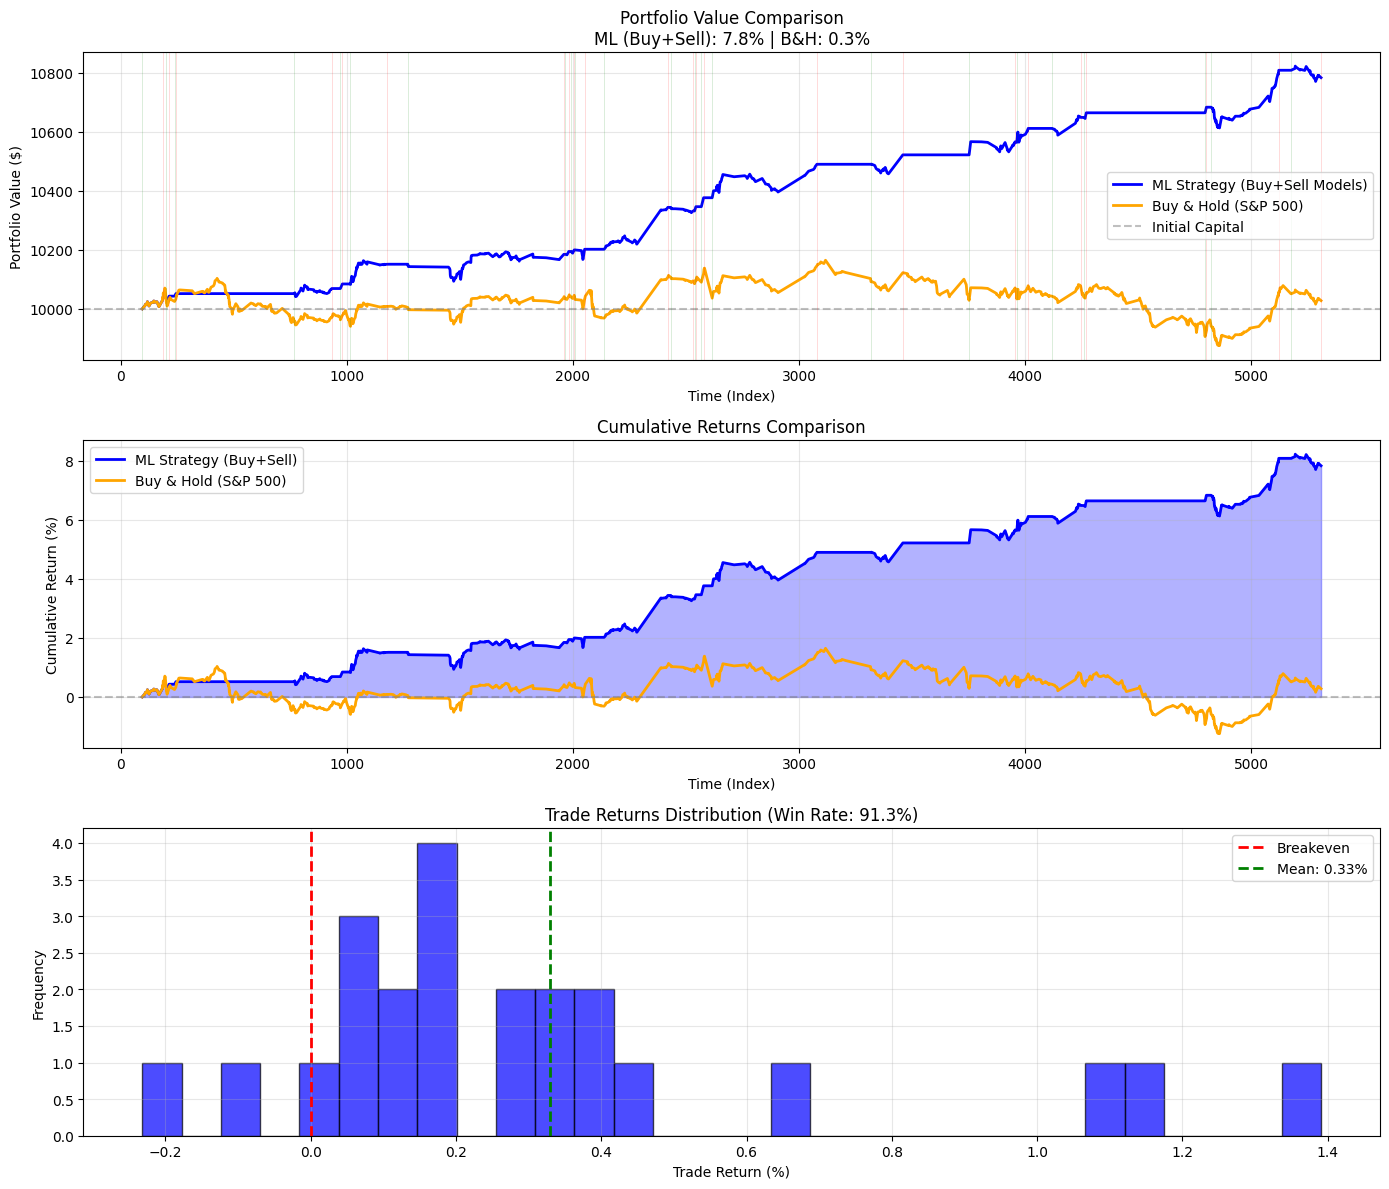

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Configuration
COMBINED_PREDICTIONS_PATH = "./output/model_results/combined_predictions.csv"
SP500_DATA_PATH = "./output/testing_bs_features/^GSPC_testing_dataset_23.4.2-4.30.csv"
OUTPUT_DIR = "./output/backtest_results"
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Strategy parameters
PROFIT_THRESHOLD_BUY = 0.5   # Buy threshold
PROFIT_THRESHOLD_SELL = 0.5  # Sell threshold (can be different!)
POSITION_SIZE = 1            # Use 100% of capital per trade
INITIAL_CAPITAL = 10000

print("=" * 80)
print("Portfolio Backtesting: Separate Buy/Sell Models vs Buy & Hold")
print("=" * 80)

# Load predictions from separate models
print("\n[1/5] Loading model predictions...")
df_signals = pd.read_csv(COMBINED_PREDICTIONS_PATH)

# Load full S&P 500 data for buy & hold
print("[2/5] Loading S&P 500 historical data...")
df_sp500 = pd.read_csv(SP500_DATA_PATH)
df_sp500 = df_sp500.sort_values('klu_idx').reset_index(drop=True)

# Sort signals by timestamp to ensure chronological order
df_signals = df_signals.sort_values('klu_idx').reset_index(drop=True)

# Get test period range (from signals)
test_start_idx = df_signals['klu_idx'].min()
test_end_idx = df_signals['klu_idx'].max()

# Filter S&P 500 data to test period
df_sp500_test = df_sp500[
    (df_sp500['klu_idx'] >= test_start_idx) & 
    (df_sp500['klu_idx'] <= test_end_idx)
].reset_index(drop=True)

print(f"S&P 500 data points in test period: {len(df_sp500_test)}")
print(f"ML signals in test period: {len(df_signals)}")
print(f"  - Buy signals:  {len(df_signals[df_signals['direction'] == 'buy'])}")
print(f"  - Sell signals: {len(df_signals[df_signals['direction'] == 'sell'])}")
print(f"Date range: {df_sp500_test['timestamp'].min()} to {df_sp500_test['timestamp'].max()}")

# Initialize portfolios
print("\n[3/5] Running backtest with separate models...")

# ML Strategy Portfolio
ml_capital = INITIAL_CAPITAL
ml_cash = INITIAL_CAPITAL
ml_shares = 0  # Number of shares held
ml_entry_price = 0
ml_trades = []
ml_returns = []
ml_skipped_sells = 0  # Track skipped sell signals
ml_skipped_buys = 0   # Track skipped buy signals

# Create a dictionary to map klu_idx to ML portfolio value
ml_portfolio_by_idx = {}

# Buy & Hold Portfolio (using full S&P 500 data)
bh_entry_price = df_sp500_test.iloc[0]['klu_close']
bh_shares = INITIAL_CAPITAL / bh_entry_price
bh_portfolio_values = []

# Calculate Buy & Hold for entire test period
for idx, row in df_sp500_test.iterrows():
    bh_portfolio_value = bh_shares * row['klu_close']
    bh_portfolio_values.append(bh_portfolio_value)

# Process ML signals using separate model predictions
for idx, row in df_signals.iterrows():
    current_price = row['klu_close']
    predicted_profit = row['predicted_profit_pct']  # Already from correct model!
    actual_profit = row['profit_target_pct']
    direction = row['direction']
    
    # Select threshold based on direction
    threshold = PROFIT_THRESHOLD_BUY if direction == 'buy' else PROFIT_THRESHOLD_SELL
    
    # === ML Strategy Logic ===
    
    if direction == 'buy' and ml_shares == 0:
        # BUY signal: Enter position if buy model predicts profit > buy threshold
        if predicted_profit >= PROFIT_THRESHOLD_BUY:
            trade_capital = ml_cash * POSITION_SIZE
            ml_shares = trade_capital / current_price
            ml_entry_price = current_price
            ml_cash -= trade_capital
            
            ml_trades.append({
                'entry_idx': idx,
                'entry_klu_idx': row['klu_idx'],
                'entry_timestamp': row['timestamp'],
                'direction': 'buy',
                'entry_price': current_price,
                'predicted_profit': predicted_profit,
                'position_size': trade_capital,
                'shares': ml_shares,
                'model_used': 'buy_model'
            })
        else:
            ml_skipped_buys += 1
    
    elif direction == 'sell' and ml_shares > 0:
        # SELL signal: Exit position if sell model predicts profit > sell threshold
        if predicted_profit >= PROFIT_THRESHOLD_SELL:
            exit_value = ml_shares * current_price
            trade_profit = exit_value - (ml_shares * ml_entry_price)
            trade_return_pct = (trade_profit / (ml_shares * ml_entry_price)) * 100
            
            ml_cash += exit_value
            
            # Record trade result
            if ml_trades:
                ml_trades[-1].update({
                    'exit_idx': idx,
                    'exit_klu_idx': row['klu_idx'],
                    'exit_timestamp': row['timestamp'],
                    'exit_price': current_price,
                    'exit_predicted_profit': predicted_profit,
                    'actual_profit': actual_profit,
                    'trade_profit': trade_profit,
                    'trade_return_pct': trade_return_pct,
                    'model_used_exit': 'sell_model'
                })
                ml_returns.append(trade_return_pct)
            
            # Reset position
            ml_shares = 0
            ml_entry_price = 0
        else:
            # Skip this sell signal (sell model predicts insufficient profit)
            ml_skipped_sells += 1
    
    # Calculate current portfolio value
    position_value = ml_shares * current_price
    ml_portfolio_value = ml_cash + position_value
    
    # Store by klu_idx for later mapping
    ml_portfolio_by_idx[row['klu_idx']] = ml_portfolio_value

# Close any open position at the end
if ml_shares > 0:
    final_price = df_signals.iloc[-1]['klu_close']
    exit_value = ml_shares * final_price
    trade_profit = exit_value - (ml_shares * ml_entry_price)
    trade_return_pct = (trade_profit / (ml_shares * ml_entry_price)) * 100
    
    ml_cash += exit_value
    
    if ml_trades:
        ml_trades[-1].update({
            'exit_idx': len(df_signals) - 1,
            'exit_klu_idx': df_signals.iloc[-1]['klu_idx'],
            'exit_timestamp': df_signals.iloc[-1]['timestamp'],
            'exit_price': final_price,
            'exit_predicted_profit': None,
            'actual_profit': None,
            'trade_profit': trade_profit,
            'trade_return_pct': trade_return_pct,
            'note': 'Closed at end of period'
        })
        ml_returns.append(trade_return_pct)
    
    ml_portfolio_by_idx[df_signals.iloc[-1]['klu_idx']] = ml_cash

# Map ML portfolio values to full timeline (forward-fill for dates without signals)
ml_portfolio_values = []
last_ml_value = INITIAL_CAPITAL
for idx, row in df_sp500_test.iterrows():
    klu_idx = row['klu_idx']
    if klu_idx in ml_portfolio_by_idx:
        last_ml_value = ml_portfolio_by_idx[klu_idx]
    ml_portfolio_values.append(last_ml_value)

# Add portfolio values to full S&P 500 dataframe
df_sp500_test['ml_portfolio_value'] = ml_portfolio_values
df_sp500_test['bh_portfolio_value'] = bh_portfolio_values

# Calculate metrics
print("\n[4/5] Calculating performance metrics...")

# ML Strategy Metrics
ml_final_value = ml_portfolio_values[-1]
ml_total_return = ((ml_final_value - INITIAL_CAPITAL) / INITIAL_CAPITAL) * 100
ml_completed_trades = len([t for t in ml_trades if 'exit_price' in t])
ml_winning_trades = len([t for t in ml_trades if 'trade_profit' in t and t['trade_profit'] > 0])
ml_win_rate = (ml_winning_trades / ml_completed_trades * 100) if ml_completed_trades > 0 else 0

# Buy & Hold Metrics
bh_final_value = bh_portfolio_values[-1]
bh_total_return = ((bh_final_value - INITIAL_CAPITAL) / INITIAL_CAPITAL) * 100

# Calculate max drawdown for ML strategy
ml_peak = INITIAL_CAPITAL
ml_max_drawdown = 0
for value in ml_portfolio_values:
    if value > ml_peak:
        ml_peak = value
    drawdown = ((ml_peak - value) / ml_peak) * 100
    if drawdown > ml_max_drawdown:
        ml_max_drawdown = drawdown

# Print results
print("\n" + "=" * 80)
print("BACKTEST RESULTS")
print("=" * 80)

print(f"\nInitial Capital: ${INITIAL_CAPITAL:,.2f}")
print(f"Trading Period: {df_sp500_test['timestamp'].min()} to {df_sp500_test['timestamp'].max()}")
print(f"Total Days: {len(df_sp500_test)}")
print(f"Total ML Signals: {len(df_signals)}")
print(f"Buy & Hold using: Full S&P 500 daily prices")

print("\n" + "-" * 80)
print("ML TRADING STRATEGY (Separate Buy/Sell Models)")
print("-" * 80)
print(f"Strategy: Use BUY model for entries, SELL model for exits")
print(f"  - Buy Threshold:  {PROFIT_THRESHOLD_BUY}% (from buy_model)")
print(f"  - Sell Threshold: {PROFIT_THRESHOLD_SELL}% (from sell_model)")
print(f"Position Size: {POSITION_SIZE*100}% per trade")
print(f"Final Portfolio Value: ${ml_final_value:,.2f}")
print(f"Total Return: {ml_total_return:.2f}%")
print(f"Max Drawdown: {ml_max_drawdown:.2f}%")
print(f"Total Trades: {len(ml_trades)} (Completed: {ml_completed_trades})")
print(f"Winning Trades: {ml_winning_trades}/{ml_completed_trades} ({ml_win_rate:.1f}%)")
print(f"Skipped Buy Signals: {ml_skipped_buys} (buy model predicted < {PROFIT_THRESHOLD_BUY}%)")
print(f"Skipped Sell Signals: {ml_skipped_sells} (sell model predicted < {PROFIT_THRESHOLD_SELL}%)")

if ml_returns:
    print(f"Average Trade Return: {np.mean(ml_returns):.2f}%")
    print(f"Median Trade Return: {np.median(ml_returns):.2f}%")
    print(f"Best Trade: {max(ml_returns):.2f}%")
    print(f"Worst Trade: {min(ml_returns):.2f}%")
    if len(ml_returns) > 1:
        print(f"Sharpe Ratio (approx): {np.mean(ml_returns) / np.std(ml_returns):.2f}")
        winning_returns = [r for r in ml_returns if r > 0]
        losing_returns = [r for r in ml_returns if r < 0]
        if winning_returns and losing_returns:
            print(f"Win/Loss Ratio: {np.mean(winning_returns) / abs(np.mean(losing_returns)):.2f}")

print("\n" + "-" * 80)
print("BUY & HOLD STRATEGY")
print("-" * 80)
print(f"Strategy: Buy at first day, hold until last day")
print(f"Entry Price: ${bh_entry_price:.2f}")
print(f"Final Price: ${df_sp500_test.iloc[-1]['klu_close']:.2f}")
print(f"Shares Held: {bh_shares:.4f}")
print(f"Final Portfolio Value: ${bh_final_value:,.2f}")
print(f"Total Return: {bh_total_return:.2f}%")

print("\n" + "-" * 80)
print("COMPARISON")
print("-" * 80)
print(f"ML Strategy vs Buy & Hold: {ml_total_return - bh_total_return:+.2f}%")
print(f"ML Strategy Outperformance: {((ml_final_value / bh_final_value - 1) * 100):+.2f}%")

if ml_total_return > bh_total_return:
    print(f"\n✅ The ML strategy OUTPERFORMED buy & hold!")
else:
    print(f"\n⚠️ The ML strategy UNDERPERFORMED buy & hold.")

# Visualizations
print("\n[5/5] Generating visualizations...")

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# 1. Portfolio Value Over Time
axes[0].plot(df_sp500_test['klu_idx'], df_sp500_test['ml_portfolio_value'], 
             label='ML Strategy (Buy+Sell Models)', linewidth=2, color='blue')
axes[0].plot(df_sp500_test['klu_idx'], df_sp500_test['bh_portfolio_value'], 
             label='Buy & Hold (S&P 500)', linewidth=2, color='orange')
axes[0].axhline(y=INITIAL_CAPITAL, color='gray', linestyle='--', alpha=0.5, label='Initial Capital')

# Mark trades on signal days
for trade in ml_trades:
    entry_klu_idx = trade['entry_klu_idx']
    axes[0].axvline(x=entry_klu_idx, color='green', alpha=0.2, linewidth=0.5)
    if 'exit_klu_idx' in trade:
        exit_klu_idx = trade['exit_klu_idx']
        axes[0].axvline(x=exit_klu_idx, color='red', alpha=0.2, linewidth=0.5)

axes[0].set_xlabel('Time (Index)')
axes[0].set_ylabel('Portfolio Value ($)')
axes[0].set_title(f'Portfolio Value Comparison\nML (Buy+Sell): {ml_total_return:.1f}% | B&H: {bh_total_return:.1f}%')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Cumulative Returns
ml_returns_series = (df_sp500_test['ml_portfolio_value'] / INITIAL_CAPITAL - 1) * 100
bh_returns_series = (df_sp500_test['bh_portfolio_value'] / INITIAL_CAPITAL - 1) * 100

axes[1].plot(df_sp500_test['klu_idx'], ml_returns_series, 
             label='ML Strategy (Buy+Sell)', linewidth=2, color='blue')
axes[1].plot(df_sp500_test['klu_idx'], bh_returns_series, 
             label='Buy & Hold (S&P 500)', linewidth=2, color='orange')
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1].fill_between(df_sp500_test['klu_idx'], ml_returns_series, 0, alpha=0.3, color='blue')
axes[1].set_xlabel('Time (Index)')
axes[1].set_ylabel('Cumulative Return (%)')
axes[1].set_title('Cumulative Returns Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Trade Distribution
if ml_returns:
    axes[2].hist(ml_returns, bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[2].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Breakeven')
    axes[2].axvline(x=np.mean(ml_returns), color='green', linestyle='--', linewidth=2, 
                    label=f'Mean: {np.mean(ml_returns):.2f}%')
    axes[2].set_xlabel('Trade Return (%)')
    axes[2].set_ylabel('Frequency')
    axes[2].set_title(f'Trade Returns Distribution (Win Rate: {ml_win_rate:.1f}%)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/backtest_separate_models.png", dpi=150, bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR}/backtest_separate_models.png")

# Save detailed trade log
if ml_trades:
    trades_df = pd.DataFrame(ml_trades)
    trades_df.to_csv(f"{OUTPUT_DIR}/trade_log_separate_models.csv", index=False)
    print(f"Saved: {OUTPUT_DIR}/trade_log_separate_models.csv")
    
    print("\nSample trades:")
    display_cols = ['entry_timestamp', 'entry_price', 'exit_price', 
                   'predicted_profit', 'exit_predicted_profit', 'trade_return_pct']
    available_cols = [col for col in display_cols if col in trades_df.columns]
    print(trades_df[available_cols].head(10).to_string(index=False))

# Save summary report
with open(f"{OUTPUT_DIR}/backtest_separate_models_summary.txt", 'w') as f:
    f.write("Portfolio Backtesting Summary Report\n")
    f.write("Separate Buy/Sell Model Strategy\n")
    f.write("=" * 80 + "\n\n")
    
    f.write("STRATEGY PARAMETERS:\n")
    f.write(f"  Buy Model Threshold:  {PROFIT_THRESHOLD_BUY}%\n")
    f.write(f"  Sell Model Threshold: {PROFIT_THRESHOLD_SELL}%\n")
    f.write(f"  Position Size: {POSITION_SIZE*100}%\n")
    f.write(f"  Initial Capital: ${INITIAL_CAPITAL:,.2f}\n")
    f.write("  Strategy: Use buy_model for entries, sell_model for exits\n")
    f.write("  Note: Entry uses buy model, exit uses sell model\n\n")
    
    f.write("DATA:\n")
    f.write(f"  Test Period: {df_sp500_test['timestamp'].min()} to {df_sp500_test['timestamp'].max()}\n")
    f.write(f"  Total Days: {len(df_sp500_test)}\n")
    f.write(f"  ML Signals: {len(df_signals)}\n")
    f.write(f"  Buy & Hold: Using full S&P 500 daily prices\n\n")
    
    f.write("ML TRADING STRATEGY (Separate Models):\n")
    f.write(f"  Final Value: ${ml_final_value:,.2f}\n")
    f.write(f"  Total Return: {ml_total_return:.2f}%\n")
    f.write(f"  Max Drawdown: {ml_max_drawdown:.2f}%\n")
    f.write(f"  Total Trades: {len(ml_trades)}\n")
    f.write(f"  Completed Trades: {ml_completed_trades}\n")
    f.write(f"  Win Rate: {ml_win_rate:.1f}%\n")
    f.write(f"  Skipped Buy Signals: {ml_skipped_buys}\n")
    f.write(f"  Skipped Sell Signals: {ml_skipped_sells}\n")
    if ml_returns:
        f.write(f"  Average Trade Return: {np.mean(ml_returns):.2f}%\n")
        f.write(f"  Median Trade Return: {np.median(ml_returns):.2f}%\n")
        f.write(f"  Best Trade: {max(ml_returns):.2f}%\n")
        f.write(f"  Worst Trade: {min(ml_returns):.2f}%\n")
    
    f.write("\nBUY & HOLD STRATEGY (S&P 500):\n")
    f.write(f"  Entry Price: ${bh_entry_price:.2f}\n")
    f.write(f"  Final Price: ${df_sp500_test.iloc[-1]['klu_close']:.2f}\n")
    f.write(f"  Final Value: ${bh_final_value:,.2f}\n")
    f.write(f"  Total Return: {bh_total_return:.2f}%\n")
    f.write(f"  Data Source: Full daily S&P 500 prices\n")
    
    f.write("\nCOMPARISON:\n")
    f.write(f"  ML vs B&H: {ml_total_return - bh_total_return:+.2f}%\n")
    f.write(f"  Outperformance: {((ml_final_value / bh_final_value - 1) * 100):+.2f}%\n")

print(f"Saved: {OUTPUT_DIR}/backtest_separate_models_summary.txt")

print("\n" + "=" * 80)
print("Backtesting Complete!")
print("=" * 80)

print(f"\nKey Takeaways:")
print(f"  - Buy & Hold uses full S&P 500 daily prices ({len(df_sp500_test)} days)")
print(f"  - ML Strategy made {ml_completed_trades} trades with {ml_win_rate:.1f}% win rate")
print(f"  - Uses SEPARATE models: buy_model for entries, sell_model for exits")
print(f"  - ML signals: {len(df_signals)} (only trade days with buy/sell signals)")
print(f"  - Average return per trade: {np.mean(ml_returns):.2f}%" if ml_returns else "  - No completed trades")
print(f"  - Skipped {ml_skipped_buys} buy signals (< {PROFIT_THRESHOLD_BUY}% threshold)")
print(f"  - Skipped {ml_skipped_sells} sell signals (< {PROFIT_THRESHOLD_SELL}% threshold)")
print(f"  - Position size: {POSITION_SIZE*100}% of capital per trade")

if ml_total_return > bh_total_return:
    print(f"\n🎯 Separate models strategy BEAT the market by {ml_total_return - bh_total_return:.2f}%!")
else:
    print(f"\n📊 Strategy needs improvement - underperformed by {abs(ml_total_return - bh_total_return):.2f}%")

plt.show()